<a name="#task1"></a>
<h3 style="color: red">Task 1: Manual Registration with OpenCV: Finding Affine Transformation</h3>

OpenCV comes with a set of functions designed for different kinds of transformations:
<ul><li><code>getAffineTransform()</code> calculates an affine transform from three pairs of the corresponding points.</li>
    <li><code>estimateRigidTransform()</code> computes an optimal affine transformation between two 2D point sets.</li>
<li><code>getPerspectiveTransform()</code> calculates a perspective transform from four pairs of the corresponding points.</li>
    <li><code>findHomography()</code> finds a perspective transformation between two planes.</li>
</ul>

<strong style="color: red">Programming Task: </strong>Find affine transformation between the images <code>screw-1.tif</code> and <code>screw-2.tif</code>. Note that you will need to find 3 pairs of corresponding points in the two images. Apply the transformation matrix to your source image and verify the result.

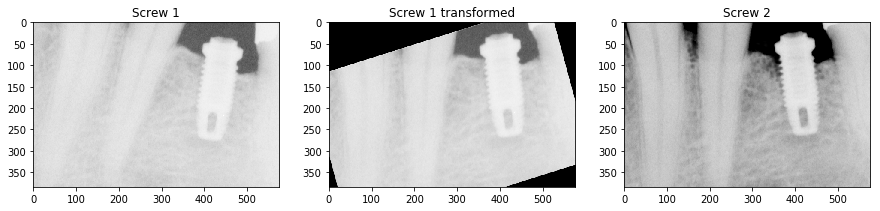

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = (15.0, 15.0)

img1 = cv.imread('screw-1.tif')
img2 = cv.imread('screw-2.tif')

rows,cols,ch = img1.shape

pts1 = np.float32([[210,15],[420,250],[450,40]])
pts2 = np.float32([[160,80],[425,240],[400,30]])

M = cv.getAffineTransform(pts1,pts2)

dst = cv.warpAffine(img1,M,(cols,rows))

plt.subplot(231), plt.imshow(img1), plt.title('Screw 1')
plt.subplot(232), plt.imshow(dst), plt.title('Screw 1 transformed')
plt.subplot(233), plt.imshow(img2), plt.title('Screw 2')
plt.show()

<a name="#task2"></a>
<h3 style="color: red">Task 2: Feature-Based Registration</h3>

Image registration can be performed automatically using interest points. The general pipeline is as
follows:
<ol>
<li>Find points or areas which are invariant to different kind of transformations (translation, rotation,
scale) and describe them using one of the existing point descriptors (SIFT, ORB, SURF, etc.). You have learned about such features in the last exercise.</li>
<li>After we have found interesting points in all the images that we want to register we try to find the corresponds between the points by calculating some distance measures (for example Euclidean
distance) between these descriptors.</li>
<li>After we establish some correspondences between the points in different images, we calculate the transformation between them (the number of corresponding points depends on the type of transformation we want to find: rigid, affine, perspective).</li>
<li><a href="http://www.cse.yorku.ca/~kosta/CompVis_Notes/ransac.pdf">Random sample consensus (RANSAC)</a> algorithm or a robust distance measure can be used to find outliers.</li>
<li>The found transformation is applied to the image we want to register.</li>
</ol>

As you have already learned there are many possible options to describe features of interest. Similarly, there are several feature matchers available in OpenCV. One of them is brute force matcher represented in OpenCV by the class <code>BFMatcher</code>. The transformation is found using <code><a href="https://docs.opencv.org/3.3.1/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780">findHomography()</a></code>. The function <code>perspectiveTransform()</code> can be used to apply the transformation.

<strong style="color: red">Programming Task:</strong> Using your mobile camera, take two photos: a photo of an object's close-up (for example, a book) and a photo of this object in the scene placed under a different angle and surrounded by other objects. Make sure that your object is feature-rich. Apply a detector of your choice to find points of interest in both photographs. We recommend using the ORB detector for this task, but you can try using any other extractor as well.

Then, apply the brute force matcher and visualize your matches.

After that, find the homography. Use the found homography to apply the perspective transformation. Can you visualize the found object by drawing a bounding box?

<strong>Remark: </strong>Don't forget to upload the photos you have taken with your camera :)

<strong>Remark:</strong> Read <a href="https://docs.opencv.org/3.4.1/dc/dc3/tutorial_py_matcher.html">OpenCV's tutorial on Feature Matching.</a> Use <code>drawMatches()</code> to visualize your matching results. <a href="https://docs.opencv.org/3.4.1/d4/d5d/group__features2d__draw.html">(see reference here)</a>.

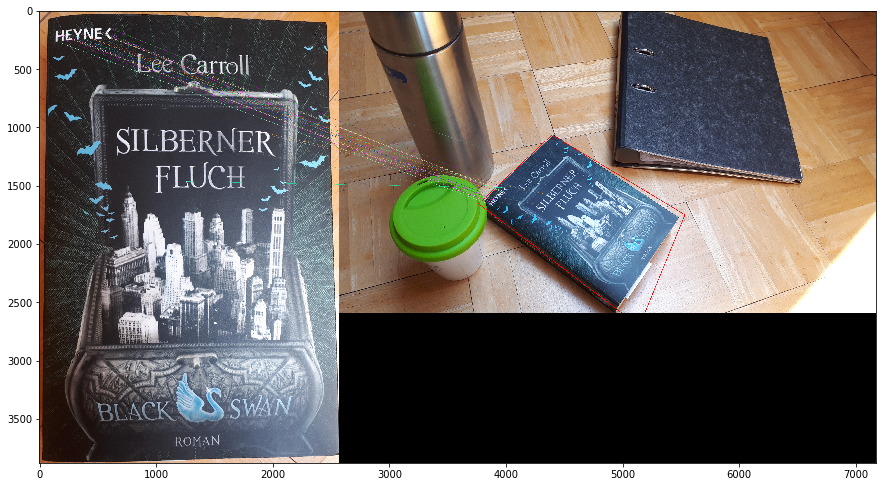

In [2]:
%matplotlib inline
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = (15.0, 15.0)

img1 = cv.imread('book1.jpg')
img2 = cv.imread('book2.jpg')

gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

orb = cv.ORB_create()
kp1,des1 = orb.detectAndCompute(gray1,None)
kp2,des2 = orb.detectAndCompute(gray2,None)

bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck = True)
matches = bf.match(des1,des2)

#sort matches in order of distance
matches = sorted(matches, key = lambda x:x.distance)

# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

# Find homography
M, mask = cv.findHomography(points1, points2, cv.RANSAC)
matchesMask = mask.ravel().tolist()

h,w = gray1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv.perspectiveTransform(pts,M)

img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
img3 = img1
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:30],img3,flags=2)

plt.imshow(img3)
plt.show()

<a name="#task3"></a>
<h3 style="color: red">Task 3: Template matching</h3>
    
Template matching is a technique for finding areas of an image that match (are similar) to a template image (patch). OpenCV comes with a function matchTemplate() for this purpose. It slides the template image over the input image and compares the template and patch of input image under the template image. Several comparison methods are implemented in OpenCV. It returns a grayscale image, where each pixel denotes how much does the neighbourhood of that pixel match with template.

<strong style="color: red">Programming Task:</strong> Download two images <code>photo-eye-1.bmp</code> and <code>Kernel.png</code>. Apply different template matching methods to find the image <code>Kernel.png</code> in the <code>photo-eye-1.bmp</code> using suitable parameters. Which method performs the best and why?

<strong style="color: red">Programming Task:</strong> Take two photos of your hand. Crop one so that it contains the hand only. This will be your template. The second photograph will be the scene: besides the hand, it shall also contain some
other objects. Apply a suitable template matching method to find the template photo in the scene.
Would this method work for the images you took for the Task 3.1?

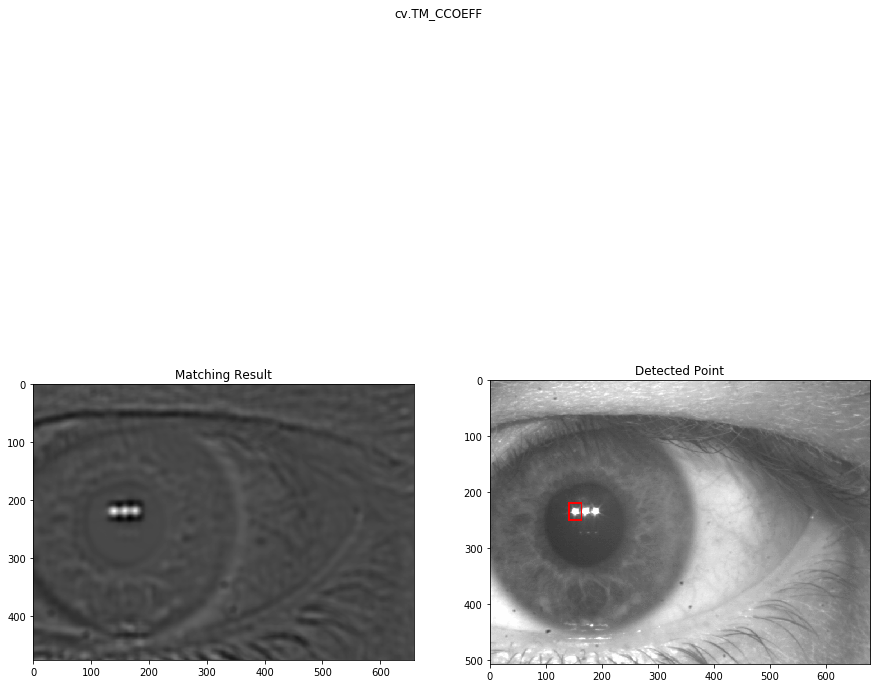

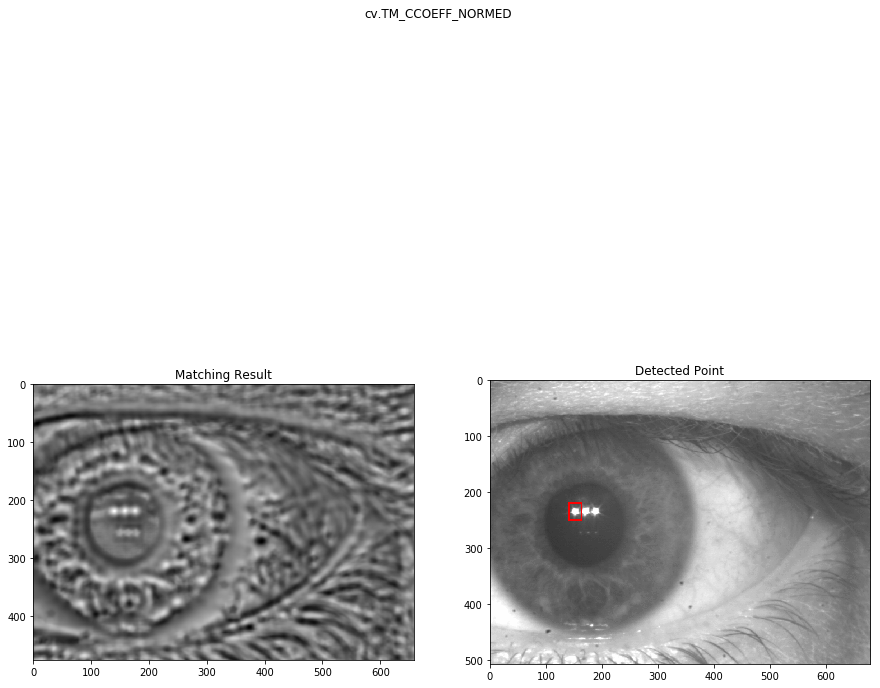

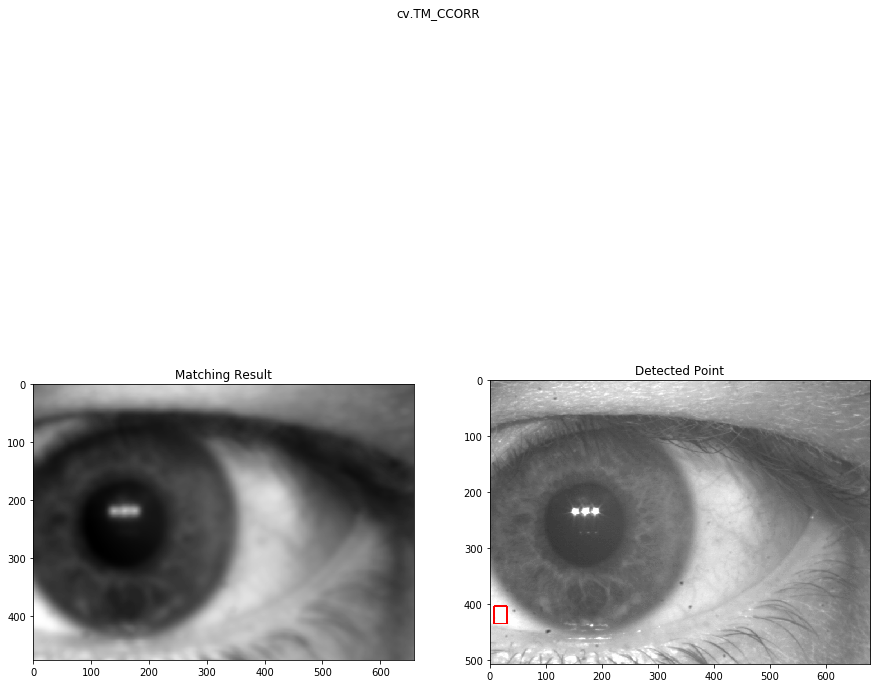

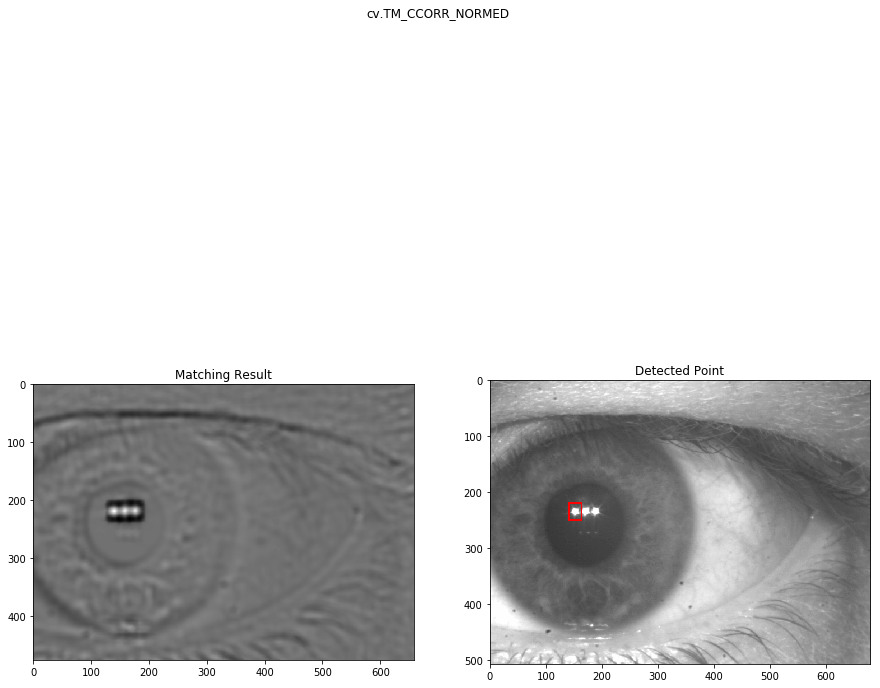

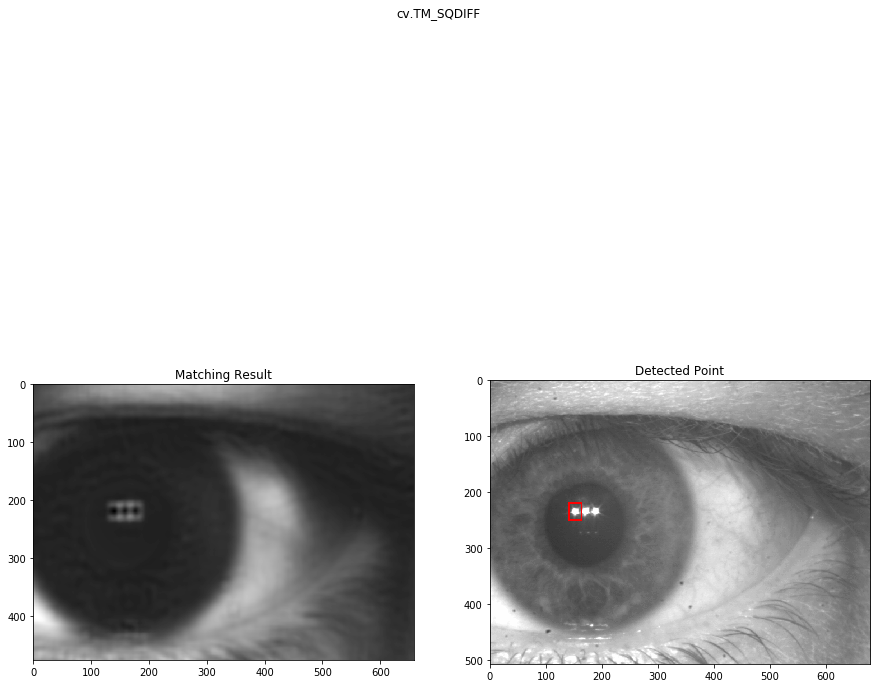

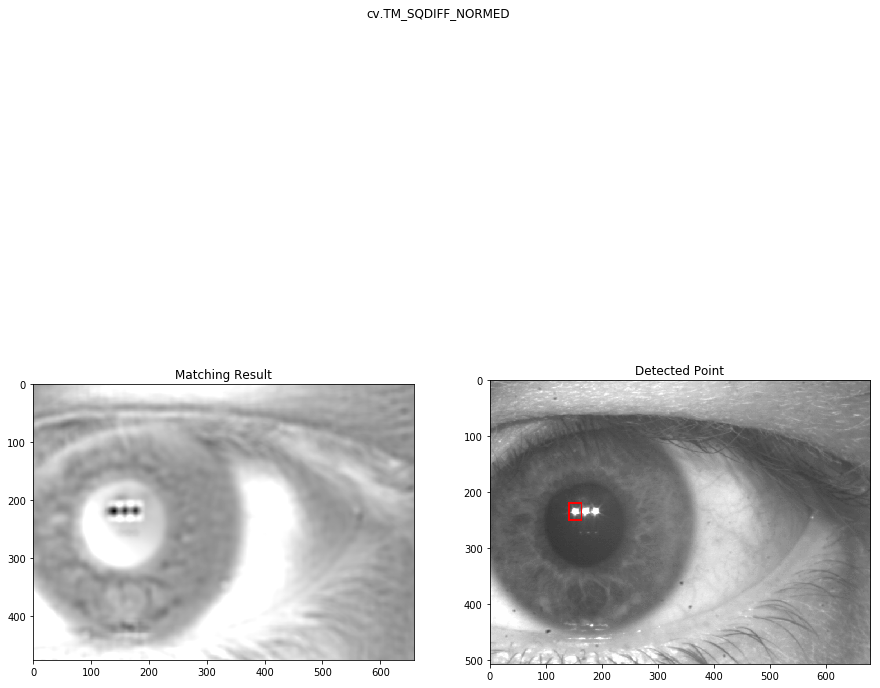

In [3]:
%matplotlib inline
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = (15.0, 15.0)

img = cv.imread('photo-eye-1.bmp')
img2 = img.copy()
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

template = cv.imread('Kernel.png',0)
w,h = template.shape[::-1]

methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

for method in methods:
    img = img2.copy()
    meth = eval(method)

    res = cv.matchTemplate(gray,template,meth)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if meth in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv.rectangle(img,top_left, bottom_right, 255, 2)
    
    plt.subplot(121),plt.imshow(res,cmap='gray')
    plt.title('Matching Result')
    plt.subplot(122),plt.imshow(img)
    plt.title('Detected Point')
    plt.suptitle(method)
    plt.show()